<a href="https://colab.research.google.com/github/supunabeywickrama/my-colab-work/blob/main/Autoencoder_Anomaly.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!nvidia-smi -L || True
import torch; print("CUDA:", torch.cuda.is_available())


GPU 0: Tesla T4 (UUID: GPU-a63d9ca3-0818-4abd-22da-e52e5619b887)
CUDA: True


In [5]:
!pip -q install torch torchvision matplotlib scikit-learn tqdm


In [6]:
import torch, torchvision as tv, torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader, Subset
import numpy as np

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Fashion-MNIST: 60k train, 10k test, classes 0..9
# We'll define: class 7 = "Sneaker" (normal); others = anomaly
NORMAL_CLASS = 7

transform = T.ToTensor()

train_full = tv.datasets.FashionMNIST(root="/content/data", train=True, download=True, transform=transform)
test_full  = tv.datasets.FashionMNIST(root="/content/data", train=False, download=True, transform=transform)

# Build splits
def idxs_by_class(ds, cls):
    return [i for i,(_,y) in enumerate(ds) if y==cls]

# Train = ONLY normal class
train_idx = idxs_by_class(train_full, NORMAL_CLASS)
# Validation/test mix: use all test data (contains normal+anomalies)
test_idx_all = list(range(len(test_full)))

train_ds = Subset(train_full, train_idx)
test_ds  = Subset(test_full, test_idx_all)

print(f"Train normals: {len(train_ds)} | Test total: {len(test_ds)}")

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds, batch_size=256, shuffle=False, num_workers=2, pin_memory=True)


100%|██████████| 26.4M/26.4M [00:02<00:00, 12.8MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 204kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.76MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 11.5MB/s]


Train normals: 6000 | Test total: 10000


In [8]:
import torch.nn as nn, torch.optim as optim
from tqdm import trange

class CAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc = nn.Sequential(
            nn.Conv2d(1, 16, 3, 2, 1), nn.ReLU(),   # 28->14
            nn.Conv2d(16,32, 3, 2, 1), nn.ReLU(),   # 14->7
            nn.Conv2d(32,64, 3, 2, 1), nn.ReLU(),   # 7->4
        )
        self.dec = nn.Sequential(
            nn.ConvTranspose2d(64,32, 3, 2, 1, output_padding=0), nn.ReLU(), # 4->7 (should be 0 for 7x7)
            nn.ConvTranspose2d(32,16, 3, 2, 1, output_padding=1), nn.ReLU(), # 7->14
            nn.ConvTranspose2d(16, 1, 3, 2, 1, output_padding=1), nn.Sigmoid() # 14->28
        )
    def forward(self,x): return self.dec(self.enc(x))

model = CAE().to(DEVICE)
opt   = optim.Adam(model.parameters(), lr=1e-3)
crit  = nn.L1Loss()

EPOCHS = 10  # quick demo; try 30 for better
for ep in trange(EPOCHS):
    model.train()
    s=0; n=0
    for xb,_ in train_loader:
        xb = xb.to(DEVICE)
        yb = model(xb)
        loss = crit(yb, xb)
        opt.zero_grad(); loss.backward(); opt.step()
        s += loss.item()*xb.size(0); n += xb.size(0)
    print(f"epoch {ep+1}: L1={s/n:.4f}")

 10%|█         | 1/10 [00:01<00:09,  1.03s/it]

epoch 1: L1=0.3215


 20%|██        | 2/10 [00:01<00:06,  1.14it/s]

epoch 2: L1=0.1680


 30%|███       | 3/10 [00:02<00:05,  1.22it/s]

epoch 3: L1=0.1677


 40%|████      | 4/10 [00:03<00:04,  1.25it/s]

epoch 4: L1=0.1677


 50%|█████     | 5/10 [00:04<00:04,  1.16it/s]

epoch 5: L1=0.1677


 60%|██████    | 6/10 [00:05<00:03,  1.04it/s]

epoch 6: L1=0.1677


 70%|███████   | 7/10 [00:06<00:03,  1.01s/it]

epoch 7: L1=0.1677


 80%|████████  | 8/10 [00:07<00:01,  1.06it/s]

epoch 8: L1=0.1677


 90%|█████████ | 9/10 [00:08<00:00,  1.11it/s]

epoch 9: L1=0.1677


100%|██████████| 10/10 [00:08<00:00,  1.12it/s]

epoch 10: L1=0.1677


In [9]:
from sklearn.metrics import roc_auc_score, roc_curve, classification_report
import numpy as np

model.eval()
scores = []
labels = []  # 0 = normal, 1 = anomaly

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(DEVICE)
        recon = model(xb)
        err = (recon - xb).abs().flatten(1).mean(dim=1)  # L1 per image
        # label: 0 if sneaker, else 1
        lbl = (yb != NORMAL_CLASS).int()
        scores.extend(err.detach().cpu().numpy().tolist())
        labels.extend(lbl.numpy().tolist())

auc = roc_auc_score(labels, scores)
print("Image AUROC:", round(auc,4))

# Choose threshold (Youden’s J)
fpr,tpr,thr = roc_curve(labels, scores)
T = thr[np.argmax(tpr - fpr)]
pred = (np.array(scores) >= T).astype(int)
print("Threshold:", float(T))
print(classification_report(labels, pred, target_names=["OK (Sneaker)","ANOM (Other)"]))


Image AUROC: 0.8242
Threshold: 0.22749170660972595
              precision    recall  f1-score   support

OK (Sneaker)       0.24      0.88      0.38      1000
ANOM (Other)       0.98      0.69      0.81      9000

    accuracy                           0.71     10000
   macro avg       0.61      0.78      0.59     10000
weighted avg       0.91      0.71      0.76     10000



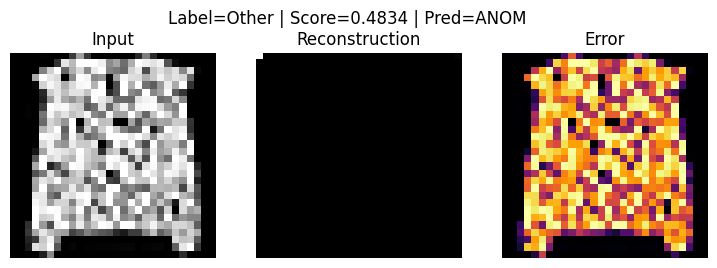

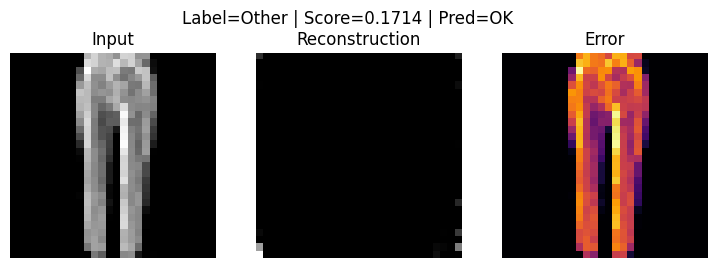

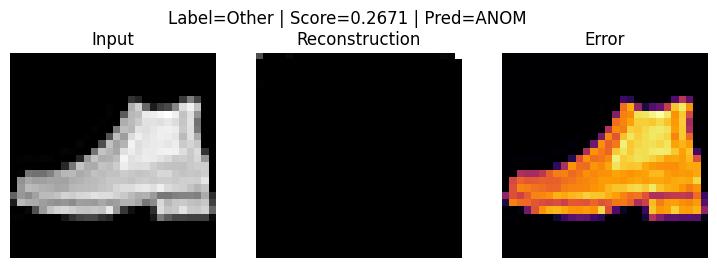

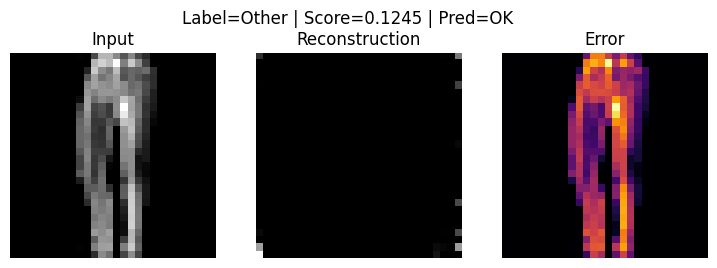

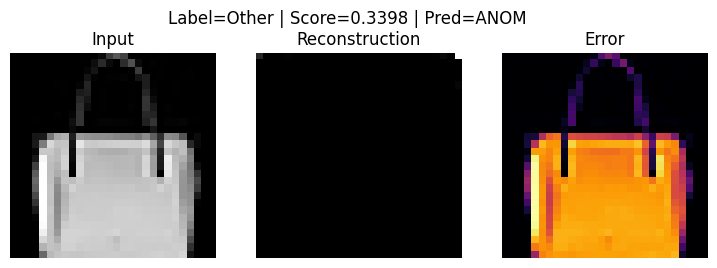

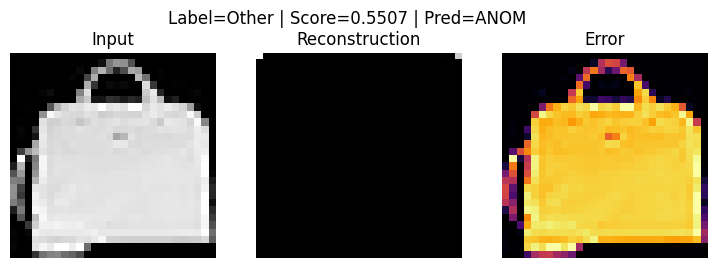

In [10]:
import matplotlib.pyplot as plt
import random, torch

def show_case(img, recon, title=""):
    x = img.squeeze(0).cpu().numpy()
    y = recon.squeeze(0).cpu().numpy()
    err = np.abs(y-x)
    plt.figure(figsize=(9,3))
    plt.subplot(1,3,1); plt.imshow(x, cmap="gray"); plt.title("Input"); plt.axis("off")
    plt.subplot(1,3,2); plt.imshow(y, cmap="gray"); plt.title("Reconstruction"); plt.axis("off")
    plt.subplot(1,3,3); plt.imshow(err, cmap="inferno"); plt.title("Error"); plt.axis("off")
    plt.suptitle(title); plt.show()

# sample a few from test set
model.eval()
for _ in range(6):
    i = random.randrange(len(test_ds))
    img, y = test_ds[i]
    with torch.no_grad():
        r = model(img.unsqueeze(0).to(DEVICE)).cpu()
        s = (r - img.unsqueeze(0)).abs().mean().item()
        title = f"Label={'Sneaker' if y==NORMAL_CLASS else 'Other'} | Score={s:.4f} | Pred={'ANOM' if s>=T else 'OK'}"
        show_case(img, r.squeeze(0), title)


In [11]:
!pip -q install torch torchvision timm scikit-learn matplotlib opencv-python tqdm
!pip -q install anomalib==1.1.0 onnx onnxruntime


In [12]:
import torchvision as tv, torchvision.transforms as T
from torch.utils.data import DataLoader, Subset
import numpy as np, torch, os, shutil, random, glob

NORMAL_CLASS = 7  # 7 = 'horse' in CIFAR-10 labels; change as you like

transform = T.Compose([T.Resize(224), T.ToTensor()])  # 224 for pretrained backbones
train_full = tv.datasets.CIFAR10("/content/data", train=True,  download=True, transform=transform)
test_full  = tv.datasets.CIFAR10("/content/data", train=False, download=True, transform=transform)

def idxs_by_class(ds, cls): return [i for i,(_,y) in enumerate(ds) if y==cls]

# Train only on NORMAL (unsupervised AD assumption)
train_idx = idxs_by_class(train_full, NORMAL_CLASS)
train_ds  = Subset(train_full, train_idx)
test_ds   = test_full  # contains both normal and anomalies

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=256, shuffle=False, num_workers=2, pin_memory=True)

print(f"Train normals: {len(train_ds)} | Test total: {len(test_ds)}")


100%|██████████| 170M/170M [00:03<00:00, 43.4MB/s]


Train normals: 5000 | Test total: 10000


In [13]:
import torch, torch.nn as nn, torch.optim as optim
import timm, random, math
from tqdm import trange

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# --- CutPaste augmentation ---
import torchvision.transforms.functional as TF
def cutpaste(img, scale=(0.02,0.15)):
    c,h,w = img.shape
    area = h*w
    target = random.uniform(*scale) * area
    rh = int(math.sqrt(target))
    rw = int(target / max(rh,1))
    y1 = random.randint(0, h-rh-1)
    x1 = random.randint(0, w-rw-1)
    patch = img[:, y1:y1+rh, x1:x1+rw].clone()
    # paste to new location
    y2 = random.randint(0, h-rh-1)
    x2 = random.randint(0, w-rw-1)
    out = img.clone()
    out[:, y2:y2+rh, x2:x2+rw] = patch
    return out

# classifier backbone
model = timm.create_model("resnet18", pretrained=True, num_classes=2).to(DEVICE)  # 0=normal,1=cutpaste
opt   = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
crit  = nn.CrossEntropyLoss()

EPOCHS = 10  # bump to 30+ for best results
for ep in trange(EPOCHS):
    model.train()
    s=n=0
    for xb,_ in train_loader:
        xb = xb.to(DEVICE)
        # half normal, half cutpaste
        xb_aug = xb.clone()
        for i in range(xb_aug.size(0)//2, xb_aug.size(0)):
            xb_aug[i] = cutpaste(xb_aug[i])
        y = torch.zeros(xb.size(0), dtype=torch.long, device=DEVICE)
        y[xb.size(0)//2:] = 1
        logits = model(xb_aug)
        loss = crit(logits, y)
        opt.zero_grad(); loss.backward(); opt.step()
        s += loss.item()*xb.size(0); n += xb.size(0)
    print(f"ep{ep+1}: loss={s/n:.4f}")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

 10%|█         | 1/10 [00:14<02:14, 14.94s/it]

ep1: loss=0.4079


 20%|██        | 2/10 [00:29<01:56, 14.52s/it]

ep2: loss=0.0371


 30%|███       | 3/10 [00:43<01:41, 14.46s/it]

ep3: loss=0.0189


 40%|████      | 4/10 [00:58<01:26, 14.49s/it]

ep4: loss=0.0128


 50%|█████     | 5/10 [01:12<01:12, 14.52s/it]

ep5: loss=0.0105


 60%|██████    | 6/10 [01:27<00:58, 14.57s/it]

ep6: loss=0.0044


 70%|███████   | 7/10 [01:42<00:44, 14.72s/it]

ep7: loss=0.0085


 80%|████████  | 8/10 [01:57<00:29, 14.82s/it]

ep8: loss=0.0102


 90%|█████████ | 9/10 [02:12<00:14, 14.87s/it]

ep9: loss=0.0078


100%|██████████| 10/10 [02:27<00:00, 14.74s/it]

ep10: loss=0.0060


# Inference (anomaly score = probability of CutPaste)

In [30]:
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score, roc_curve, classification_report
import numpy as np

model.eval()
scores, labels = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        lab = (yb != NORMAL_CLASS).int()        # anomaly if not the normal class
        p = F.softmax(model(xb.to(DEVICE)), dim=1)[:,1]  # prob of 'cutpaste' class
        scores.extend(p.detach().cpu().numpy().tolist())
        labels.extend(lab.numpy().tolist())

# Save labels and scores to numpy files
np.save("labels.npy", np.array(labels))
np.save("scores.npy", np.array(scores))

auc = roc_auc_score(labels, scores)
print("CutPaste AUROC:", round(auc,4))

fpr,tpr,thr = roc_curve(labels, scores)
T = thr[np.argmax(tpr - fpr)]
pred = (np.array(scores) >= T).astype(int)
print("Threshold:", float(T))
print(classification_report(labels, pred, target_names=["OK","ANOM"]))

CutPaste AUROC: 0.6729
Threshold: 0.010718019679188728
              precision    recall  f1-score   support

          OK       0.16      0.65      0.25      1000
        ANOM       0.94      0.61      0.74      9000

    accuracy                           0.61     10000
   macro avg       0.55      0.63      0.49     10000
weighted avg       0.86      0.61      0.69     10000



# Convert CIFAR-10 to folder dataset for anomalib

In [15]:
ROOT = "/content/cifar10_folder"
for p in [f"{ROOT}/train/good", f"{ROOT}/test/good", f"{ROOT}/test/defect"]:
    os.makedirs(p, exist_ok=True)

# dump train (only NORMAL_CLASS)
for i,(img,y) in enumerate(train_ds):
    tv.utils.save_image(img, f"{ROOT}/train/good/{i:06d}.png")

# dump test (normal + anomaly)
for i,(img,y) in enumerate(test_ds):
    sub = "good" if y==NORMAL_CLASS else "defect"
    tv.utils.save_image(img, f"{ROOT}/test/{sub}/{i:06d}.png")

!tree -L 3 /content/cifar10_folder | sed -n '1,200p'


/bin/bash: line 1: tree: command not found


In [16]:
# Calibrate threshold to a target FPR (e.g., 1%) using a small normal-only calibration split
target_fpr = 0.01
# Use your ROC (fpr,tpr,thr) from CutPaste or PatchCore outputs:
# Find threshold with fpr <= target_fpr
idx = np.where(fpr <= target_fpr)[0]
T_prod = thr[idx[-1]] if len(idx) else thr[np.argmin(fpr)]
print("Production threshold (FPR<=1%):", float(T_prod))


Production threshold (FPR<=1%): 0.07666105031967163


In [18]:
dummy = torch.randn(1,3,224,224, device=DEVICE)
torch.onnx.export(model, dummy, "/content/cutpaste_resnet18.onnx",
                  input_names=["input"], output_names=["logits"],
                  opset_version=13)
import onnx, onnxruntime as ort
onnx_model = onnx.load("/content/cutpaste_resnet18.onnx"); onnx.checker.check_model(onnx_model)
sess = ort.InferenceSession("/content/cutpaste_resnet18.onnx", providers=["CPUExecutionProvider"])
print("ONNX ready.")


/tmp/ipython-input-1193007612.py:2: DeprecationWarning: You are using the legacy TorchScript-based ONNX export. Starting in PyTorch 2.9, the new torch.export-based ONNX exporter will be the default. To switch now, set dynamo=True in torch.onnx.export. This new exporter supports features like exporting LLMs with DynamicCache. We encourage you to try it and share feedback to help improve the experience. Learn more about the new export logic: https://pytorch.org/docs/stable/onnx_dynamo.html. For exporting control flow: https://pytorch.org/tutorials/beginner/onnx/export_control_flow_model_to_onnx_tutorial.html.
  torch.onnx.export(model, dummy, "/content/cutpaste_resnet18.onnx",


ONNX ready.


In [22]:
!pip install onnxscript -q

In [24]:
import torch

dummy = torch.randn(1, 3, 224, 224, device=DEVICE)

torch.onnx.export(
    model, dummy, "/content/cutpaste_resnet18.onnx",
    input_names=["input"], output_names=["logits"],
    opset_version=17,          # good modern default
    dynamo=False,               # <-- use legacy exporter
    do_constant_folding=True,
    dynamic_axes={"input": {0: "batch"}, "logits": {0: "batch"}}
)
print("Exported with legacy ONNX exporter (dynamo=False).")

/tmp/ipython-input-1642220931.py:5: DeprecationWarning: You are using the legacy TorchScript-based ONNX export. Starting in PyTorch 2.9, the new torch.export-based ONNX exporter will be the default. To switch now, set dynamo=True in torch.onnx.export. This new exporter supports features like exporting LLMs with DynamicCache. We encourage you to try it and share feedback to help improve the experience. Learn more about the new export logic: https://pytorch.org/docs/stable/onnx_dynamo.html. For exporting control flow: https://pytorch.org/tutorials/beginner/onnx/export_control_flow_model_to_onnx_tutorial.html.
  torch.onnx.export(


Exported with legacy ONNX exporter (dynamo=False).


In [25]:
import onnx, onnxruntime as ort, numpy as np

onnx_model = onnx.load("/content/cutpaste_resnet18.onnx")
onnx.checker.check_model(onnx_model)

sess = ort.InferenceSession("/content/cutpaste_resnet18.onnx", providers=["CPUExecutionProvider"])
x = np.random.randn(1,3,224,224).astype("float32")
probs = sess.run(["logits"], {"input": x})[0]
print("ORT logits shape:", probs.shape)


ORT logits shape: (1, 2)


In [26]:
# onnx_infer.py
import onnxruntime as ort, numpy as np, cv2, glob, json, os

IMG_SIZE = 224
ONNX_PATH = "cutpaste_resnet18.onnx"     # your exported file
THRESHOLD = 0.42                         # replace with your calibrated value

def preprocess_bgr(img_bgr):
    img = cv2.resize(img_bgr, (IMG_SIZE, IMG_SIZE))
    img = img[:, :, ::-1].astype("float32")/255.0   # BGR->RGB, [0,1]
    img = np.transpose(img, (2,0,1))                # CHW
    return img[None, ...]                            # NCHW

def score_paths(img_paths):
    sess = ort.InferenceSession(ONNX_PATH, providers=["CPUExecutionProvider"])
    out_name = sess.get_outputs()[0].name
    inp_name = sess.get_inputs()[0].name
    out = []
    for p in img_paths:
        x = preprocess_bgr(cv2.imread(p))
        logits = sess.run([out_name], {inp_name: x})[0]           # [N,2]
        # anomaly score = prob of 'cutpaste' class
        e = np.exp(logits - logits.max(axis=1, keepdims=True))
        prob = (e[:,1] / e.sum(axis=1))[0].item()
        out.append({"path": p, "score": prob, "pred": "ANOM" if prob>=THRESHOLD else "OK"})
    return out

if __name__ == "__main__":
    paths = glob.glob("samples/*.jpg") + glob.glob("samples/*.png")
    res = score_paths(paths)
    print(json.dumps(res, indent=2))


[]


In [28]:
mean = np.array([0.485, 0.456, 0.406])[:,None,None]
std  = np.array([0.229, 0.224, 0.225])[:,None,None]
img = (img - mean)/std



/tmp/ipython-input-2763200514.py:3: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  img = (img - mean)/std


In [31]:
import numpy as np

# Suppose you already have these from evaluation:
# labels = [...]  # 0 for normal, 1 for anomaly
# scores = [...]  # float anomaly scores

np.save("labels.npy", np.array(labels))
np.save("scores.npy", np.array(scores))

print("Saved labels.npy and scores.npy")


Saved labels.npy and scores.npy


In [32]:
import numpy as np, json
from sklearn.metrics import roc_curve

labels = np.load("labels.npy")
scores = np.load("scores.npy")

fpr, tpr, thr = roc_curve(labels, scores)
target_fpr = 0.01
idx = np.where(fpr <= target_fpr)[0]
T = float(thr[idx[-1]] if len(idx) else thr[np.argmin(fpr)])
print("Chosen threshold:", T)

with open("threshold.json", "w") as f:
    json.dump({"threshold": T}, f)


Chosen threshold: 0.07666105031967163


In [33]:
import json
with open("threshold.json") as f:
    THRESHOLD = json.load(f)["threshold"]


In [34]:
# batch_infer.py
import csv, glob, json
from onnx_infer import score_paths

paths = glob.glob("eval/normal/*") + glob.glob("eval/anomaly/*")
res = score_paths(paths)
with open("preds.csv","w",newline="") as f:
    w=csv.DictWriter(f, fieldnames=["path","score","pred"]); w.writeheader(); w.writerows(res)
print("Wrote preds.csv")


ModuleNotFoundError: No module named 'onnx_infer'

In [35]:
# Create onnx_infer.py
%%writefile onnx_infer.py
import onnxruntime as ort, numpy as np, cv2, glob, json, os

IMG_SIZE = 224
ONNX_PATH = "cutpaste_resnet18.onnx"     # your exported file
THRESHOLD = 0.42                         # replace with your calibrated value

def preprocess_bgr(img_bgr):
    img = cv2.resize(img_bgr, (IMG_SIZE, IMG_SIZE))
    img = img[:, :, ::-1].astype("float32")/255.0   # BGR->RGB, [0,1]
    img = np.transpose(img, (2,0,1))                # CHW
    return img[None, ...]                            # NCHW

def score_paths(img_paths):
    sess = ort.InferenceSession(ONNX_PATH, providers=["CPUExecutionProvider"])
    out_name = sess.get_outputs()[0].name
    inp_name = sess.get_inputs()[0].name
    out = []
    for p in img_paths:
        x = preprocess_bgr(cv2.imread(p))
        logits = sess.run([out_name], {inp_name: x})[0]           # [N,2]
        # anomaly score = prob of 'cutpaste' class
        e = np.exp(logits - logits.max(axis=1, keepdims=True))
        prob = (e[:,1] / e.sum(axis=1))[0].item()
        out.append({"path": p, "score": prob, "pred": "ANOM" if prob>=THRESHOLD else "OK"})
    return out

if __name__ == "__main__":
    paths = glob.glob("samples/*.jpg") + glob.glob("samples/*.png")
    res = score_paths(paths)
    print(json.dumps(res, indent=2))

Writing onnx_infer.py


In [37]:
import json
with open("threshold.json") as f:
    THRESHOLD = json.load(f)["threshold"]

In [39]:
# example: take your timm backbone and export it for feature extraction
import timm, torch
from collections import OrderedDict

class FeatNet(torch.nn.Module):
    def __init__(self, name="resnet18"):
        super().__init__()
        m = timm.create_model(name, pretrained=True, num_classes=0)  # returns features
        self.backbone = m
    def forward(self, x):
        f = self.backbone(x)  # [N, D]
        return f

net = FeatNet("resnet18").eval().to(DEVICE)
dummy = torch.randn(1,3,224,224, device=DEVICE)
torch.onnx.export(net, dummy, "resnet18_feats.onnx",
                  input_names=["input"], output_names=["feat"], opset_version=17, dynamo=False) # Changed dynamo to False

/tmp/ipython-input-89438696.py:16: DeprecationWarning: You are using the legacy TorchScript-based ONNX export. Starting in PyTorch 2.9, the new torch.export-based ONNX exporter will be the default. To switch now, set dynamo=True in torch.onnx.export. This new exporter supports features like exporting LLMs with DynamicCache. We encourage you to try it and share feedback to help improve the experience. Learn more about the new export logic: https://pytorch.org/docs/stable/onnx_dynamo.html. For exporting control flow: https://pytorch.org/tutorials/beginner/onnx/export_control_flow_model_to_onnx_tutorial.html.
  torch.onnx.export(net, dummy, "resnet18_feats.onnx",
